# CNN Depth Measurements - Comparison with 'Standard' Techniques
---
Chris Simpson

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import TensorBoard

from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPool1D, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.models import Model
from pathlib import Path

# Helper libraries
import seaborn as sns
import time
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import hilbert

from undt_ai.load import load_pipeline, load_single
from undt_ai.tools import rmse, normal
from undt_ai.synthetic_build import n_layer_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, CSVLogger
#sns.set(style="ticks")

print(tf.__version__)

2.1.0


## Locate Data Files and Load
---

In [2]:
data_folder = 'OneDrive - University of Bristol/Projects\Current projects/2018-20 Turing Fellowship/Chris data etc/Data'

In [3]:
fpath_s = Path.home().joinpath(data_folder, 'synth_data.npz')
fpath_sf = Path.home().joinpath(data_folder, 'synth_flat.npz')
out_dir = Path.home().joinpath(data_folder)

In [4]:
data = load_pipeline(fpath_s, levels =[0])
t,data = data[:3], data[3:]
t = t[0][0]

x_train, x_val, x_test = data[:3]
Dmin_train, Dmin_val, Dmin_test = data[3:6]
D_train, D_val, D_test = data[6:9]
rms_train, rms_val, rms_test = data[9:]

y_train, y_val, y_test = D_train, D_val, D_test


In [5]:
print(t.shape)

(255, 1)


## Data Overview
---

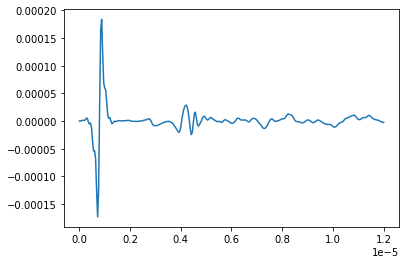

In [6]:
#tb, _, _, _, _ = load_single_wtime(fpath_sf, crop=0)
tb, xb, _, _, _ = load_single(fpath_s, crop=0)

select=192
plt.plot(tb[0], xb[select])

from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(12, 4.))

axarr = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,3),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )

root_path = Path.home() / 'Google Drive/1851traceData/'

for i, (f, letter, sig, lambd) in enumerate(zip(['run33/corrosionMapIteration361.npy', 
                                  'run38/corrosionMapIteration491.npy',
                                   'run39/corrosionMapIteration49.npy'], ['(a)', '(b)', '(c)'],
                                 [0.14, 0.52, 0.60], [1.0, 1.0, 0.5])):
    mp = np.load(root_path / f)
    corr_map = axarr[i].contourf(np.arange(0,77) * 0.25, np.arange(0,77) * 0.25, 1000 * mp, 
                                 cmap='viridis', levels=np.linspace(-2.,2., 11))
    txt = f'{letter} ' + r'$\sigma=$' + f'{sig:.2f}, ' + r'$\lambda=$' + f'{lambd:.1f}'
    axarr[i].text(s=txt, x=1.5, y=17., bbox=dict(facecolor='w', edgecolor='k', pad=5.0))
    axarr[i].set_xlabel('x (mm)')
    axarr[i].plot(np.array([7, 7, 13, 13, 7]) - 0.5, np.array([7, 13, 13, 7, 7]) - 0.5, ls='--', c='0.1')
    
##cbar = plt.colorbar(corr_map)

axarr[0].set_ylabel('y (mm)')
clab = axarr[-1].cax.colorbar(corr_map)
axarr[-1].cax.toggle_label(True)
clab.set_label_text('z (mm)')
#fig.colorbar(corr_map, ax=axarr.ravel().tolist())

#fig.tight_layout()
#plt.axis('equal')

figpath = Path.home().joinpath('Dropbox/Projects/undt-ai/figures/')
fig.savefig(figpath / 'params_dist_map_ap.png', dpi=400)


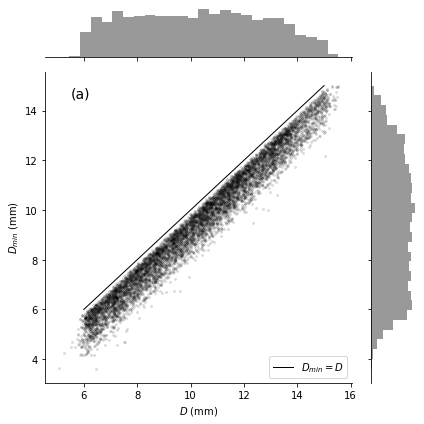

In [7]:
g = sns.jointplot(1e3*D_train, 1e3*Dmin_train, s=4, alpha=0.1, color='k').set_axis_labels("$D$ (mm)", "$D_{min}$ (mm)")
g.ax_joint.plot([6, 15], [6, 15], 'k-', lw=1, label='$D_{min} = D$')  
g.ax_joint.text(5.5, 14.5, '(a)', size=14)
g.ax_joint.legend(loc=4)

plt.tight_layout()
figpath = Path.home().joinpath(data_folder, 'figures')
plt.savefig(figpath / 'params_dist_D.png', dpi=400)

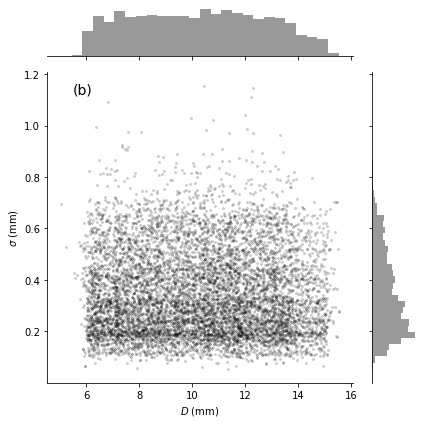

In [8]:
g = sns.jointplot(1e3*D_train, 1e3*rms_train, s=4, alpha=0.15, color='k').set_axis_labels("$D$ (mm)", "$\sigma$ (mm)")
#g.ax_joint.plot([6, 15], [6, 15], 'k-', lw=1, label='$D_{min} = D$')  
g.ax_joint.text(5.5, 1.125, '(b)', size=14)
plt.tight_layout()
plt.savefig(figpath / 'params_dist_rms.png', dpi=400)

# Measured Dmin and Dmean: CNN w/ Linear Regression
Use a regression activation function (loss function = MSE) on the final layer to predict a continuous value for thickness. Use the full (downsampled) data.

### Model Setup
---
- 2 Conv Layers w/ Pooling and Dropout on FCN
- Split off 20% of the data to test the model
- We'll also use a validation/development training set of a similar size (for TensorBoard!)


# CNN Architecture: Create and Save 3 Layer CNN

In [9]:
model = n_layer_model(n_layers=3, filters=64, kernel_size=71, 
                        drop_layers=[-1], drop_fraction=0.2, pool_step=0, batch_norm=True)
model.summary()

ipath = Path.home().joinpath(data_folder, 'D_3L_71K_BN_D0p2_initial.h5')
model.save(ipath)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 255, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 185, 64)           4608      
_________________________________________________________________
batch_normalization (BatchNo (None, 185, 64)           256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 115, 64)           290880    
_________________________________________________________________
batch_normalization_1 (Batch (None, 115, 64)           256       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 45, 64)            290880    
_________________________________________________________________
batch_normalization_2 (Batch (None, 45, 64)            256   

# CNN - $D_{mean}$

Load the saved initial model - key point is to reload the custom metric

model_D = tf.keras.models.load_model(ipath, custom_objects={'rmse': rmse})

spath = Path.home().joinpath(data_folder, 'D_3L_71K_BN_D0p2.h5')

#reduce_lr = ReduceLROnPlateau(patience=50, min_delta=0, factor=0.5, monitor='val_loss')
model_checkpoint = ModelCheckpoint(filepath=spath.as_posix(), monitor='val_loss',
                                   save_best_only=True)
model_D.fit(normal(x_train), [1000 * D_train], 
            epochs=600, batch_size=128, 
            validation_data=[normal(x_val), 1e3*y_val], callbacks=[model_checkpoint,])

model_D.load_weights(spath.as_posix())
# Training Progression
plt.figure(figsize=(5.5, 4.25))
epochs = model_D.history.epoch
plt.semilogy(epochs, model_D.history.history['rmse'], label='Train', color='C0')
plt.semilogy(epochs, model_D.history.history['val_rmse'], label='Validation', color='C1')
plt.axhline(0.11, c='k', ls=':', label=f'RMSE = 0.11mm')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE (mm)')
plt.ylim(1e-1, 1)
plt.text(0, .85, '(a)', bbox={'facecolor':'w', 'edgecolor':'w'}, size=12)
plt.tight_layout()
figpath = Path.home().joinpath('Dropbox/Projects/undt-ai/figures/')
plt.savefig(figpath / 'D_training.png', dpi=400)

spath = Path.home().joinpath('Dropbox/Projects/undt-ai/Data/D_3L_71K_BN_D0p2.h5')
model_D.load_weights(spath.as_posix())
metrics = model_D.evaluate(normal(x_test), [1e3*D_test], verbose=0)
y_hat_D = model_D.predict(normal(x_test))

rmse_D = np.mean((y_hat_D.flatten() - 1e3 * D_test.flatten())**2)**0.5
mae_D = np.mean(np.abs(y_hat_D.flatten() - 1e3 * D_test.flatten()))
me_D = np.mean(y_hat_D.flatten() - 1e3 * D_test.flatten())

plt.figure(figsize=(5.5, 4.5))
plt.plot(1e3 * D_test, y_hat_D, 'k.', alpha=0.1)
plt.plot([6,15],[6, 15], 'r')
plt.axis('equal')
plt.ylabel(r'$\hat{D}$ (mm)')
plt.xlabel('$D$ (mm)')

print(f'RMSE = {rmse_D:.3f}mm')
print(f'MAE = {mae_D:.2f}mm')
figpath = Path.home().joinpath('Dropbox/Projects/undt-ai/figures/')
plt.savefig(figpath / 'D_Dhat_CNN.png', dpi=400)


# CNN - $D_{min}$

# Callbacks
spath = Path.home().joinpath('Dropbox/Projects/undt-ai/Data/Dmin_3L_71K_BN_0p2Dmin.h5')
csv_logger_Dmin = CSVLogger(spath.parent / 'Dmin_3L_71K_BN_0p2D.csv')
reduce_lr_Dmin = ReduceLROnPlateau(patience=100, min_delta=0, factor=0.75)
model_checkpoint_Dmin = ModelCheckpoint(filepath=spath.as_posix(), monitor='val_loss',
                                   save_best_only=True)
callbacks = [model_checkpoint_Dmin, csv_logger_Dmin]

# Load initialised model (i.e. with initial weights) - stops training getting stuck with stuff stored in GPU mem
ipath = Path.home().joinpath('Dropbox/Projects/undt-ai/Data/D_3L_71K_BN_D0p2_initial.h5')
model_Dmin = tf.keras.models.load_model(ipath, custom_objects={'rmse': rmse})

# Train
model_Dmin.fit(normal(x_train), [1000 * Dmin_train], 
               epochs=600, batch_size=128, 
               validation_data=[normal(x_val), 1e3*Dmin_val], callbacks=callbacks)

spath = Path.home().joinpath('Dropbox/Projects/undt-ai/Data/Dmin_3L_71K_BN_0p2Dmin.h5')

model_Dmin.load_weights(spath.as_posix())
metrics_Dmin = model_Dmin.evaluate(normal(x_test), [1000*Dmin_test], verbose=0)

y_hat_Dmin = model_Dmin.predict(normal(x_test))
rmse_Dmin = np.mean((y_hat_Dmin.flatten() - 1e3 * Dmin_test.flatten())**2)**0.5
mae_Dmin = np.mean(np.abs(y_hat_Dmin.flatten() - 1e3 * Dmin_test.flatten()))
me_Dmin = np.mean(y_hat_Dmin.flatten() - 1e3 * Dmin_test.flatten())

figpath.joinpath('Dmin_training.png').as_posix()

spath = Path.home().joinpath('Dropbox/Projects/undt-ai/Data/Dmin_3L_71K_BN_0p2Dmin.h5')
model_Dmin.load_weights(spath.as_posix())
# Training Progression
plt.figure(figsize=(5.5, 4.25))
epochs = model_Dmin.history.epoch
plt.semilogy(epochs, model_Dmin.history.history['rmse'], label='Train', color='C0')
plt.semilogy(epochs, model_Dmin.history.history['val_rmse'], label='Validation', color='C1')
plt.axhline(0.2, c='k', ls=':', label=f'RMSE = 0.20mm')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE (mm)')
plt.ylim(1e-1, 1)
plt.tight_layout()
plt.text(0, .85, '(b)', bbox={'facecolor':'w', 'edgecolor':'w'}, size=12)

figpath = Path.home().joinpath('Dropbox/Projects/undt-ai/figures/')
plt.savefig(figpath / 'Dmin_training.png', dpi=400)

plt.plot(1e3 * Dmin_test, y_hat_Dmin, 'k.', alpha=0.1)
plt.plot([4.5,15],[4.5, 15], 'r')
plt.axis('equal')
plt.ylabel(r'$\hat{D_{min}}$ (mm)'), plt.xlabel(r'$D_{min}$ (mm)')
print(f'RMSE = {rmse_Dmin:.3f}mm')
print(f'MAE = {mae_Dmin:.2f}mm')
figpath = Path.home().joinpath('Dropbox/Projects/undt-ai/figures/')
plt.savefig(figpath / 'Dmin_Dminhat_CNN.png', dpi=400)

# Combined CNN Assessment

fig, axarr = plt.subplots(1, 2, sharey=True, figsize=(9, 4.5))
epochs = model_Dmin.history.epoch
axarr[1].semilogy(epochs, model_Dmin.history.history['rmse'], label='Train')
axarr[1].semilogy(epochs, model_Dmin.history.history['val_rmse'], label='Validation')
axarr[1].axhline(0.21, c='k', ls=':', label=f'RMSE = 0.21 mm')
axarr[1].legend()
axarr[1].set_xlabel('Epoch')
axarr[1].set_ylim(1e-1, 1)

epochs = model_D.history.epoch
axarr[0].semilogy(epochs, model_D.history.history['rmse'], label='Train')
axarr[0].semilogy(epochs, model_D.history.history['val_rmse'], label='Validation')
axarr[0].axhline(0.114, c='k', ls=':', label=f'RMSE = 0.11 mm')
axarr[0].legend()
axarr[0].set_xlabel('Epoch')
axarr[0].set_ylabel('RMSE (mm)')
axarr[0].set_ylim(1e-1, 1)
plt.tight_layout()


figpath = Path.home().joinpath('Dropbox/Projects/undt-ai/figures/')
plt.savefig(figpath / 'D_Dmin_training.png', dpi=400)

plt.plot(y_hat_D, y_hat_Dmin, 'k.', alpha=0.1, label='$\hat{y}$')
plt.plot(1e3*D_test, 1e3*Dmin_test, 'r.', alpha=0.1, label='$y$')

#plt.plot([4.5,15],[4.5, 15], 'r')
plt.axis('equal')
plt.ylabel('$D_{min}$ (mm)')
plt.xlabel('$D$ (mm)')
plt.legend()

fig, axarr = plt.subplots(1, 2, figsize=(8, 3.5), sharex=True)

axarr[0].plot(1e3 * D_test, y_hat_D, 'k.', alpha=0.1)
axarr[0].plot([5.5,15],[5.5, 15], 'r')
# axarr[1].axis('equal')
axarr[0].set_ylabel(r'$\hat{D}$ (mm)'), axarr[0].set_xlabel(r'$D$ (mm)')


axarr[1].plot(1e3 * Dmin_test, y_hat_Dmin, 'k.', alpha=0.1)
axarr[1].plot([4.5,15],[4.5, 15], 'r')
# axarr[1].axis('equal')
axarr[1].set_ylabel(r'$\hat{D_{min}}$ (mm)'), axarr[1].set_xlabel(r'$D_{min}$ (mm)')

plt.tight_layout()
figpath = Path.home().joinpath('Dropbox/Projects/undt-ai/figures/')
plt.savefig(figpath / 'D_Dmin_hat_CNN.png', dpi=400)

# $D_{mean}$ From Peak (NOT Peak of Envelope)
No longer used!

In [11]:
D_test.shape

(3104, 1)

In [12]:
c_fe = 5700  #  (m/s) Approx. speed of sound in stainless steel
offset = 0.85 / 1e6

t, x_flat, Dmin_flat, D_flat, _ = load_single(fpath_sf, crop=45)
t = t[0]
dt = t[1] - t[0]

# Correction via flat plate
peak_est_flat = (D_flat.flatten() * 2 / (c_fe))
peak_offset_flat = peak_est_flat + offset
arg_peak_est_flat = np.argmin(np.abs(t - peak_offset_flat), axis=0)


# Correct on rough data
peak_est = (D_test.flatten() * 2 / (c_fe))
peak_offset = peak_est + offset
arg_peak_est = np.argmin(np.abs(t - peak_offset), axis=0)

### Use Flat Plate to Find Velocity/Offset

(2.0, 7.0)

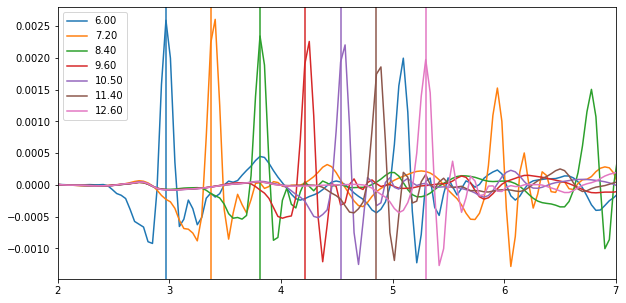

In [13]:
c_fe = 5670  #  (m/s) Approx. speed of sound in stainless steel
offset = 0.84 / 1e6

t, x_flat, Dmin_flat, D_flat, _ = load_single(fpath_sf, crop=45)
t = t[0]
dt = t[1] - t[0]

# Correction via flat plate
peak_est_flat = (D_flat.flatten() * 2 / (c_fe))
peak_offset_flat = peak_est_flat + offset
arg_peak_est_flat = np.argmin(np.abs(t - peak_offset_flat), axis=0)

plt.figure(figsize=(10, 5))
for idx, select in enumerate([0, 4,  8, 12, 15, 18, 22]):
    plt.axvline(1e6 * t[arg_peak_est_flat[select]], color=f'C{idx}')
    plt.plot(1e6*t, x_flat[select], color=f'C{idx}', label=f'{1e3 * D_flat[select][0]:.2f}')
plt.legend()
plt.xlim(2, 7)

In [14]:
# Use estimated position to iterate and find actual peak
arg_peak = []

for idx, i in enumerate((arg_peak_est * 1.25).astype(int)):
    arg_peak.append(np.argmax(x_test[idx, :i]))

t_0 = offset 
dt_pulse = t[np.array(arg_peak)] - t_0

In [15]:
y_hat_D_pwin = 1e3 * c_fe * dt_pulse / 2

rmse_D_pwin = np.mean((y_hat_D_pwin.flatten() - 1e3 * D_test.flatten())**2)**0.5
mae_D_pwin = np.mean(np.abs(y_hat_D_pwin.flatten() - 1e3 * D_test.flatten()))
me_D_pwin = np.mean(y_hat_D_pwin.flatten() - 1e3 * D_test.flatten())

RMSE = 0.51mm
MAE = 0.35mm


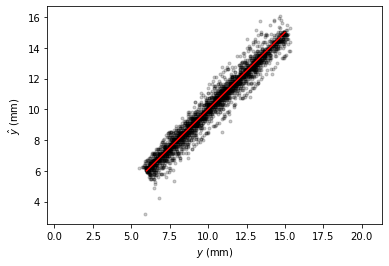

In [16]:
# Viz results
plt.plot(1e3 * D_test, y_hat_D_pwin, 'k.', alpha=0.2)
plt.plot([6, 15], [6, 15], 'r-')
plt.axis('equal')
plt.ylabel(r'$\hat{y}$ (mm)'), plt.xlabel(r'$y$ (mm)')

print(f'RMSE = {rmse_D_pwin:.2f}mm')
print(f'MAE = {mae_D_pwin:.2f}mm')

# $D_{mean}$ From Peak of Envelope

In [17]:
D_test.shape

(3104, 1)

In [18]:
c_fe = 5700  #  (m/s) Approx. speed of sound in stainless steel
offset = 0.8 / 1e6

t, x_flat, Dmin_flat, D_flat, _ = load_single(fpath_sf, crop=45)
t = t[0]
dt = t[1] - t[0]

# Correction via flat plate
peak_est_flat = (D_flat.flatten() * 2 / (c_fe))
peak_offset_flat = peak_est_flat + offset
arg_peak_est_flat = np.argmin(np.abs(t - peak_offset_flat), axis=0)


# Correct on rough data
peak_est = (D_test.flatten() * 2 / (c_fe))
peak_offset = peak_est + offset
arg_peak_est = np.argmin(np.abs(t - peak_offset), axis=0)

### Use Flat Plate to Find Velocity/Offset

(2.0, 7.0)

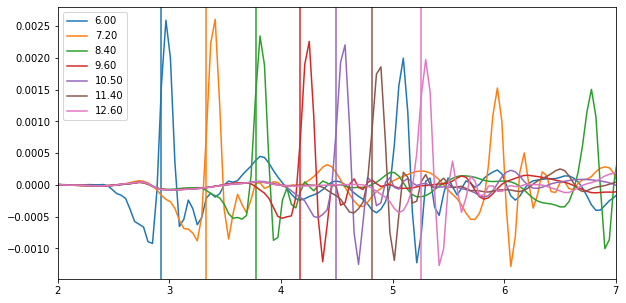

In [19]:
c_fe = 5670  #  (m/s) Approx. speed of sound in stainless steel
offset = 0.8 / 1e6

t, x_flat, Dmin_flat, D_flat, _ = load_single(fpath_sf, crop=45)
t = t[0]
dt = t[1] - t[0]

# Correction via flat plate
peak_est_flat = (D_flat.flatten() * 2 / (c_fe))
peak_offset_flat = peak_est_flat + offset
arg_peak_est_flat = np.argmin(np.abs(t - peak_offset_flat), axis=0)

plt.figure(figsize=(10, 5))
for idx, select in enumerate([0, 4,  8, 12, 15, 18, 22]):
    plt.axvline(1e6 * t[arg_peak_est_flat[select]], color=f'C{idx}')
    plt.plot(1e6*t, x_flat[select], color=f'C{idx}', label=f'{1e3 * D_flat[select][0]:.2f}')
plt.legend()
plt.xlim(2, 7)

In [20]:
# Use estimated position to iterate and find actual peak
arg_peak = []
arg_thresh = []
window = 50
for idx, i in enumerate((arg_peak_est).astype(int)):
    rand = np.random.randint(3)
    i += rand
    i_min = i - window if i > window else 0
    signal = x_test[idx, i_min:i+window][:,0]
    analytic_signal = hilbert(signal)
    amplitude_envelope = np.abs(analytic_signal)
    amplitude_envelope /= np.max(amplitude_envelope)
    peak_of_envelope = np.argmax(amplitude_envelope) 
    
    env_rev = amplitude_envelope[:peak_of_envelope][::-1]
    thresh = np.argwhere(env_rev < 0.3)[0, 0]
    peak_thresh = peak_of_envelope - thresh
    
    arg_peak.append(peak_of_envelope + i_min)
    arg_thresh.append(peak_thresh + i_min)

t_0 = offset 
dt_pulse_thresh = t[np.array(arg_thresh)] - t_0
dt_pulse = t[np.array(arg_peak)] - t_0

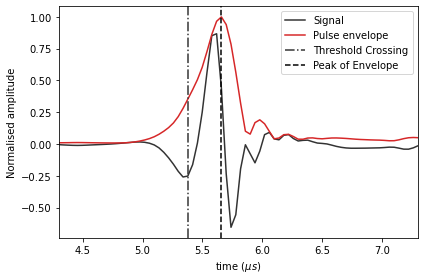

In [21]:

plt.plot(1e6 * t[i_min:i+window], signal/np.max(np.abs(analytic_signal)), label='Signal', c='0.2')
plt.plot(1e6 * t[i_min:i+window], np.abs(analytic_signal)/np.max(np.abs(analytic_signal)), label='Pulse envelope', c='C3')

plt.axvline(1e6 * t[peak_thresh + i_min], lw=1.5, ls='-.', c='0.2', label='Threshold Crossing')
#plt.plot(1e6 * t[peak_thresh + i_min], np.abs(analytic_signal[peak_thresh])/np.max(np.abs(analytic_signal)), 'ro', label='Threshold Crossing')

plt.axvline(1e6 * t[peak_of_envelope + i_min], c='k', ls='--', label='Peak of Envelope')

plt.xlim(4.3, 7.3)
plt.legend()
plt.xlabel(r'time ($\mu s$)')
plt.ylabel('Normalised amplitude')
plt.tight_layout()
plt.savefig(figpath / 'conventional_approch.png', dpi=400)

[0.10059695]


(0.0, 0.3)

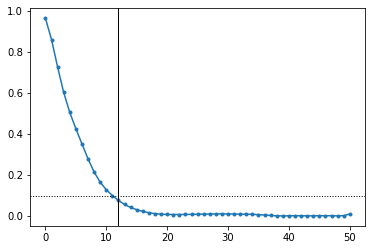

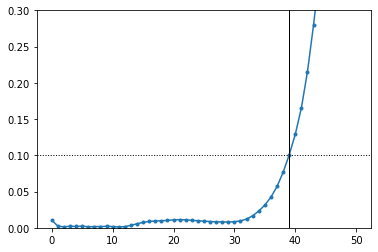

In [22]:
env_rev = amplitude_envelope[:peak_of_envelope][::-1]
thresh = np.argwhere(env_rev < 0.1)[0]
plt.plot(env_rev, '.-')
plt.axvline(thresh, c='k', lw=1)
plt.axhline(0.1, c='k', lw=1, ls=':')
# plt.xlim(10.75, 11.25)
# plt.ylim(0.08, 0.12)
plt.figure()
arg_thresh = peak_of_envelope - thresh
plt.plot(amplitude_envelope[:peak_of_envelope], '.-')
plt.axvline(arg_thresh, c='k', lw=1)
print(amplitude_envelope[arg_thresh])
plt.axhline(0.1, c='k', lw=1, ls=':')
plt.ylim(0, 0.3)

In [23]:
y_hat_D_pwin = 1e3 * c_fe * dt_pulse / 2

rmse_D_pwin = np.mean((y_hat_D_pwin.flatten() - 1e3 * D_test.flatten())**2)**0.5
mae_D_pwin = np.mean(np.abs(y_hat_D_pwin.flatten() - 1e3 * D_test.flatten()))
me_D_pwin = np.mean(y_hat_D_pwin.flatten() - 1e3 * D_test.flatten())

RMSE = 0.65mm
MAE = 0.45mm


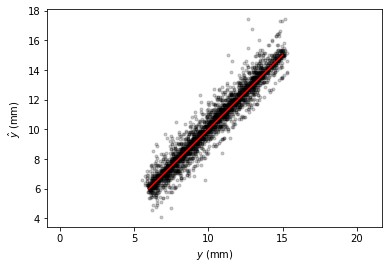

In [24]:
# Viz results
plt.plot(1e3 * D_test, y_hat_D_pwin, 'k.', alpha=0.2)
plt.plot([6, 15], [6, 15], 'r-')
plt.axis('equal')
plt.ylabel(r'$\hat{y}$ (mm)'), plt.xlabel(r'$y$ (mm)')

print(f'RMSE = {rmse_D_pwin:.2f}mm')
print(f'MAE = {mae_D_pwin:.2f}mm')

In [25]:
y_hat_Dmin_pwin = 1e3 * c_fe * dt_pulse_thresh / 2

rmse_Dmin_pwin = np.mean((y_hat_Dmin_pwin.flatten() - 1e3 * Dmin_test.flatten())**2)**0.5
mae_Dmin_pwin = np.mean(np.abs(y_hat_Dmin_pwin.flatten() - 1e3 * Dmin_test.flatten()))
me_Dmin_pwin = np.mean(y_hat_Dmin_pwin.flatten() - 1e3 * Dmin_test.flatten())

RMSE = 0.70mm
MAE = 0.46mm


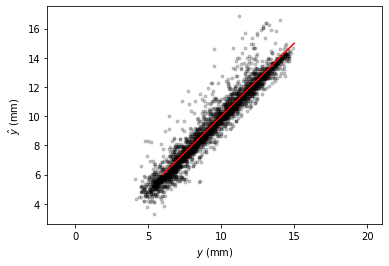

In [26]:
# Viz results
plt.plot(1e3 * Dmin_test, y_hat_Dmin_pwin[:, 0], 'k.', alpha=0.2)
plt.plot([6, 15], [6, 15], 'r-')
plt.axis('equal')
plt.ylabel(r'$\hat{y}$ (mm)'), plt.xlabel(r'$y$ (mm)')

print(f'RMSE = {rmse_Dmin_pwin:.2f}mm')
print(f'MAE = {mae_Dmin_pwin:.2f}mm')

In [ ]:
plt.plot(y_hat_D_pwin, y_hat_Dmin_pwin, 'k.', alpha=0.2)
plt.plot([5, 15], [5, 15], 'r-')
plt.axis('equal')
plt.ylabel(r'$\hat{y}$ (mm)')
plt.xlabel(r'$y$ (mm)')

# Comparison

In [ ]:
fig, axarr = plt.subplots(1,2, sharex=True,sharey=True, figsize=(8.5, 4.25))
kwargs = {'cumulative': True}
sns.distplot(1e3 * D_test - y_hat_D, 
             ax=axarr[0], bins=np.linspace(-3, 3, 91), label=r'$D^{CNN}$')
sns.distplot(1e3 * Dmin_test - y_hat_Dmin, 
             ax=axarr[1], bins=np.linspace(-3, 3, 91), label=r'$D_{min}^{CNN}$')

sns.distplot(1e3 * D_test - y_hat_D_pwin, 
             ax=axarr[0], bins=np.linspace(-3, 3, 91), color='C1', label=r'$D^{peak}$')

sns.distplot(1e3 * Dmin_test - y_hat_Dmin_pwin, 
             ax=axarr[1], bins=np.linspace(-3, 3, 91), color='C1', label=r'$D_{min}^{thresh}$')


for ax in axarr.flatten():
    ax.legend()

axarr[0].set_xlim(-1.7, 1.7)

# axarr[0].set_ylim(axarr[0].get_ylim())
# axarr[1].set_yticklabels([])
axarr[0].text(-1.5, 4.4, r'(a) $D$', size=14)
axarr[1].text(-1.5, 4.4, r'(b) $D_{min}$', size=14)


axarr[0].set_xlabel(r'$ D - \hat{D}$ (mm)')
axarr[1].set_xlabel(r'$ D_{min} - \hat{D}_{min}$ (mm)')

axarr[0].set_ylabel(r'Density')

fig.tight_layout()

figpath = Path.home().joinpath('Dropbox/Projects/undt-ai/figures/')
fig.savefig(figpath / 'D_Dmin_distribution_simple.png', dpi=400)

In [ ]:
fig, axarr = plt.subplots(2, 2, sharex=True, figsize=(8, 7.25))
kwargs = {'cumulative': True}
sns.distplot(1e3 * D_test - y_hat_D, 
             ax=axarr[0, 0], bins=np.linspace(-3, 3, 91), label=r'$D^{CNN}$')
sns.distplot(1e3 * Dmin_test - y_hat_Dmin, 
             ax=axarr[0, 1], bins=np.linspace(-3, 3, 91), label=r'$D_{min}^{CNN}$')

sns.distplot(1e3 * D_test - y_hat_D_pwin, 
             ax=axarr[0, 0], bins=np.linspace(-3, 3, 91), color='C1', label=r'$D^{peak}$')

sns.distplot(1e3 * Dmin_test - y_hat_Dmin_pwin, 
             ax=axarr[0, 1], bins=np.linspace(-3, 3, 91), color='C1', label=r'$D_{min}^{thresh}$')


sns.distplot(1e3 * D_test - y_hat_D, hist_kws=kwargs, 
             kde_kws=kwargs, ax=axarr[1, 0], bins=np.linspace(-3, 3, 91), label=r'$D^{CNN}$')

sns.distplot(1e3 * Dmin_test - y_hat_Dmin, hist_kws=kwargs, 
             kde_kws=kwargs, ax=axarr[1, 1], bins=np.linspace(-3, 3, 91), label=r'$D_{min}^{CNN}$')

sns.distplot(1e3 * D_test - y_hat_D_pwin, hist_kws=kwargs, kde_kws=kwargs, 
             ax=axarr[1, 0], bins=np.linspace(-3, 3, 91), color='C1', label=r'$D^{peak}$')
sns.distplot(1e3 * Dmin_test - y_hat_Dmin_pwin, hist_kws=kwargs, kde_kws=kwargs, 
             ax=axarr[1, 1], bins=np.linspace(-3, 3, 91), color='C1', label=r'$D_{min}^{thresh}$')

for ax in axarr.flatten():
    ax.legend()

axarr[0, 0].set_xlim(-1.5, 1.5)

axarr[0, 1].set_ylim(axarr[0, 0].get_ylim())
axarr[0, 1].set_yticklabels([])
axarr[1, 1].set_yticklabels([])
axarr[0, 0].set_title(r'$D$', size=14)
axarr[0, 1].set_title(r'$D_{min}$', size=14)


axarr[1, 0].set_xlabel(r'$ D - \hat{D}$ (mm)')
axarr[1, 1].set_xlabel(r'$ D_{min} - \hat{D}_{min}$ (mm)')

axarr[0, 0].set_ylabel(r'Density')
axarr[1, 0].set_ylabel(r'Probability')

axarr[0,0].text
fig.tight_layout()

figpath = Path.home().joinpath('Dropbox/Projects/undt-ai/figures/')
fig.savefig(figpath / 'D_Dmin_distribution.png', dpi=400)

In [21]:
fpath_s

WindowsPath('C:/Users/mepdw/OneDrive - University of Bristol/Projects/Current projects/2018-20 Turing Fellowship/Chris data etc/Data/synth_data.npz')

# Old Plots- needs to be rerun to include

In [ ]:
# Dmin - needs to be rerun with new results!!
plt.plot(1e3 * Dmin_test, y_hat_Dmin_pwin, 'k.', alpha=0.2, label=f'Thresh: {rmse_Dmin_pth:.2f} mm')
plt.plot(1e3 * Dmin_test, y_hat_Dmin, 'r.', alpha=0.2, label=f'CNN: {rmse_Dmin:.2f} mm')
plt.legend()
plt.axis('equal')
plt.ylabel('$\hat{y}$ (mm)')
plt.xlabel('$y$ (mm)')
plt.tight_layout()

In [ ]:
#sns.distplot(1e3 * Dmin_test - y_hat_Dmin_pval, kde=True)
kwargs = {'cumulative': True}
sns.distplot(1e3 * Dmin_test - y_hat_Dmin_pwin, hist_kws=kwargs, kde_kws=kwargs, label=f'ZC: ±{rmse_Dmin_pth:.2f}')
sns.distplot(1e3 * Dmin_test - y_hat_Dmin, hist_kws=kwargs, kde_kws=kwargs, label=f'CNN: ±{rmse_Dmin:.2f}')
plt.xlim(-3, 3)
plt.ylabel('Probability')
plt.legend()
plt.xlabel(r'$ D_{min} - \hat{D}_{min}$ (mm)')
plt.tight_layout()

In [ ]:
# Dmean - needs to be rerun with new results!!
plt.figure(figsize=(5.5, 4.5))
plt.plot(1e3 * D_test, y_hat_D_pwin, 'k.', alpha=0.2, label=f'Thresh: RMSE = {rmse_D_pwin:.2f}')
plt.plot(1e3 * D_test, y_hat_D, 'r.', alpha=0.2, label=f'CNN: RMSE = {rmse_D:.2f}')
plt.legend()
plt.axis('equal')
plt.ylabel(r'$\hat{y}$ (mm)')
plt.xlabel('$y$ (mm)')
plt.ylim(3.7, 16.3)
plt.tight_layout()
plt.save_fig

In [ ]:
#sns.distplot(1e3 * Dmin_test - y_hat_Dmin_pval, kde=True)
kwargs = {'cumulative': True}
sns.distplot(1e3 * D_test - y_hat_D_pwin, hist_kws=kwargs, kde_kws=kwargs, label=f'Peak: ±{rmse_D_pwin:.2f}')
#plt.xlim(-3, 3)
#plt.figure()
sns.distplot(1e3 * D_test - y_hat_D, hist_kws=kwargs, kde_kws=kwargs, label=f'CNN: ±{rmse_D:.2f}')
plt.xlim(-3, 3)
plt.legend()
plt.ylabel('Probability')
plt.xlabel(r'$ D - \hat{D}$ (mm)')

# Experimental D Calcs - IGNORE (See Coupon_Models-Grid Search)

In [ ]:
from undt_ai.load import load_single
from pathlib import Path
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
from undt_ai.tools import normal

fpath_s = Path.home().joinpath('Dropbox/Projects/undt-ai/Data/synth_data_fft_vel.npz')
fpath_pkl = Path.home().joinpath('Dropbox/Projects/undt-ai/Data/synth_data_params.pkl')
data = np.load(fpath_s)
df = pd.read_pickle(fpath_pkl)

fpath_e_coup = Path.home().joinpath('Dropbox/Projects/undt-ai/Data/exp_coupons.npz')
t_coup, signal_coup, Dmin_coup, D_coup, rms_coup = load_single(fpath_e_coup, crop=0)

i06a = 'run38/Iteration491'
i06b = 'run33/Iteration192'
i09a = 'run38/Iteration489'
i09b = 'run23/s75'
i13a = 'run33/Iteration361'
i13b = 'run38/Iteration125'
runs = [i06a, i06b, i09a, i09b, i13a, i13b]

In [ ]:
c_fe = 5670  #  (m/s) Approx. speed of sound in stainless steel
offset = 0.84 / 1e6
t_0 = offset

t_c_fft, t_c_exp = [], []
exp_idxs = []
for run in runs:
    
    plt.figure()
    D = df.loc[run]['D']
    exp_idx = np.argmax(D_coup == D)
    exp_idxs.append(exp_idx)
    idx = df.index.get_loc(run)
    #print(idx)

    
    for idx, (signal, i, l, t_c) in enumerate(zip([normal(data['signal'], start_idx=60), normal(signal_coup, start_idx=60)], 
                                             [idx, exp_idx], ['Synth (FFT)', 'Exp'], [t_c_fft, t_c_exp])):
        am = np.argmax(signal[i][crop:])
        peak_pos = t_coup[0][60:][am]
        t_c.append(peak_pos)
        
        plt.plot(1e6*t_coup[0], signal[i], label=l, c=f'C{idx}')
        plt.axvline(1e6*peak_pos, c=f'C{idx}')
        
        #plt.plot(1e6*t_coup[0], normal(signal_coup, start_idx=60)[exp_idx], label='Exp')
        plt.legend()
        plt.ylim(-1.5, 1.5)
        plt.xlim(0, 8)
        plt.xlabel(r'time ($\mu s$)')
        plt.ylabel('Normalised amplitude')
        
t_c_fft = np.array(t_c_fft)
t_c_exp = np.array(t_c_exp)

dt_max_fft = t_c_fft - t_0
dt_max_exp = t_c_exp - t_0

y_hat_D_max_fft = 1e3 * c_fe * dt_max_fft / 2
y_hat_D_max_exp = 1e3 * c_fe * dt_max_exp / 2

In [ ]:

plt.plot(1e3*D_coup[exp_idxs], y_hat_D_max_fft, 'ro', label='FFT', mfc='w')
plt.plot(1e3*D_coup[exp_idxs], y_hat_D_max_exp, 'ko', label='Exp', mfc='w')
plt.plot([6, 15], [6, 15], 'k-')
plt.legend()
plt.grid()
rmse = np.mean((1e3*D_coup[exp_idxs] - y_hat_D_max_exp)**2)**0.5
print(rmse)

In [ ]:
(1e3*D_coup - y_hat_D_max_exp)

In [ ]:
1e3*D_coup, y_hat_D_max_exp

In [ ]:
c_fe = 5670  #  (m/s) Approx. speed of sound in stainless steel
offset = 0.84 / 1e6
t_0 = offset

t_c = []
for run in runs:
    #plt.figure()
    D = df.loc[run]['D']
    exp_idx = np.argmax(D_coup == D)
    idx = df.index.get_loc(run)
    #print(idx)
    sig = data['signal']
    crop = 60
    plt.plot(1e6*t_coup[0][crop:], signal_coup[idx][crop:])
    am = np.argmax(signal_coup[idx][crop:])
    peak_pos = t_coup[0][crop:][am]
    t_c.append(peak_pos)
    plt.axvline(1e6*peak_pos, color='k')
t_c = np.array(t_c)
dt_max_exp = t_c - t_0
y_hat_D_max_exp = 1e3 * c_fe * dt_max_exp / 2

In [ ]:
for i in signal_coup:
    plt.plot(i)
    

In [ ]:
c_fe = 5670  #  (m/s) Approx. speed of sound in stainless steel
offset = 0.84 / 1e6
t_0 = offset

t_c = []
for idx in range(6):
    crop = 60
    plt.plot(1e6*t_coup[0][crop:], signal_coup[idx][crop:])
    am = np.argmax(signal_coup[idx][crop:])
    peak_pos = t_coup[0][crop:][am]
    t_c.append(peak_pos)
    plt.axvline(1e6*peak_pos, color='k')
t_c = np.array(t_c)
dt_max_exp = t_c - t_0
y_hat_D_max_exp = 1e3 * c_fe * dt_max_exp / 2

In [ ]:
plt.plot(D_coup, y_hat_D_max_exp, '.')
plt.plot([6, 15], [6, 15], 'k-')
rmse = np.mean(((D_coup - y_hat_D_max_exp)**2))**0.5
print(rmse)

In [ ]:
#Compared Exp with Synthetic

In [ ]:
import pandas as pd
fpath_s = Path.home().joinpath('Dropbox/Projects/undt-ai/Data/synth_data.npz')
fpath_pkl = Path.home().joinpath('Dropbox/Projects/undt-ai/Data/synth_data_params.pkl')
data = np.load(fpath_s)
df = pd.read_pickle(fpath_pkl)

# t_coup, signal_coup, Dmin_coup, D_coup, rms_coup = load_single(fpath_e_coup, crop=0)
# signal_coup[:, :20] = 0
# D_coup = D_coup * 1000

In [ ]:
exp_coupons = 
df

In [ ]:
data['params']